###Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import nltk
import random
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Dataset

In [0]:
train=pd.read_csv('/content/drive/My Drive/Toxic Comment Dataset/train.csv')
df_test=pd.read_csv('/content/drive/My Drive/Toxic Comment Dataset/test.csv')
test_labels = pd.read_csv('/content/drive/My Drive/Toxic Comment Dataset/test_labels.csv')
sample_submission =pd.read_csv('/content/drive/My Drive/Toxic Comment Dataset/sample_submission.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
test_labels = test_labels[(test_labels[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]
print(test_labels.shape)

(63978, 7)


In [8]:
# merge with an inner join
test = pd.merge(test_labels, df_test, on='id', how='inner')
print(test.shape)
test.head()

(63978, 8)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."


###Plot Labels in Bar Graph

In [0]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

[478, 1405, 1595, 7877, 8449, 15294]
clean               143346
threat              478
identity_hate       1405
severe_toxic        1595
insult              7877
obscene             8449
toxic               15294


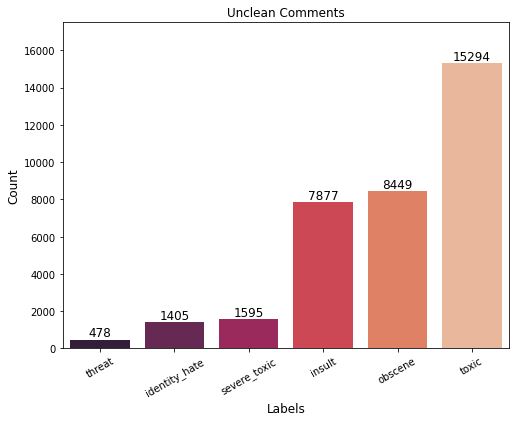

In [10]:
x=train.iloc[:,2:].sum()
rowsum=train.iloc[:,2:].sum(axis=1)
clean=[]
clean=(rowsum==0)
clean=clean.sum()
x=x.tolist()
labels.sort(key=dict(zip(labels, x)).get)
x=sorted(x)
print(x)
print('{:<20s}{:>1s}'.format('clean',str(clean)))
for i in range (0,6):
   print('{:<20s}{:>1s}'.format(labels[i],str(x[i])))

#x.append(clean)
fig, ax = plt.subplots( figsize=(8,6))
rects1 = ax.bar(labels,x,color='b')
#plt.bar(labels,x,color=['yellow', '#00e020', '#20a0ff', '#ff6020', '#a000e0','#ff2020'])
sns.barplot(labels,x,palette='rocket')

plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.ylim(0,17500)
plt.xticks(labels, fontsize=10, rotation=30)
plt.title('Unclean Comments')
for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom',fontsize=12)
plt.show()
#sns.barplot(labels,x,palette='muted')
#plt.title("Unclean Comments")
#plt.show()

###Plot Correlation Heat Map

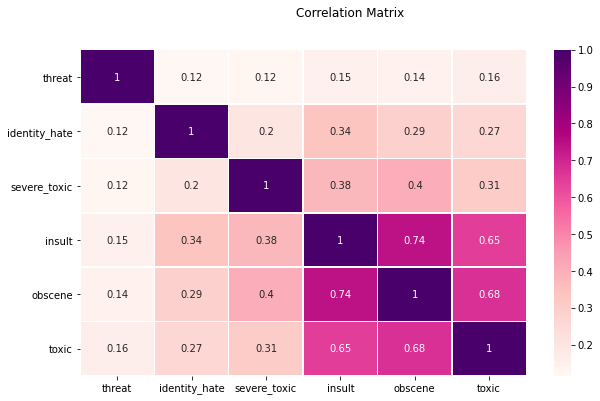

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train[labels].corr(), annot=True, cmap="RdPu", linewidths=.5, ax=ax);

### Plot top 20 toxic words in toxic comments.

In [0]:
toxic_comments=train[train.toxic==1]['comment_text']
toxic_comments=toxic_comments[:10000].tolist()
toxic_cleaned=[]
corpus=[]
cnt=0
for text in toxic_comments:
    text=re.sub('[^a-zA-Z]', ' ',text)
    text=text.lower()
    text=text.split()
    for word in text:
      if(word not in set(stopwords.words('english'))):
        corpus.append(word)
    #text=[word for word in text if not word in set(stopwords.words('english'))]
commonly_toxic=Counter(corpus)

['fuck', 'shit', 'nigger', 'like', 'wikipedia', 'ass', 'fucking', 'u', 'suck', 'gay', 'go', 'die', 'get', 'hate', 'know', 'page', 'pig', 'cunt', 'bitch', 'fat']


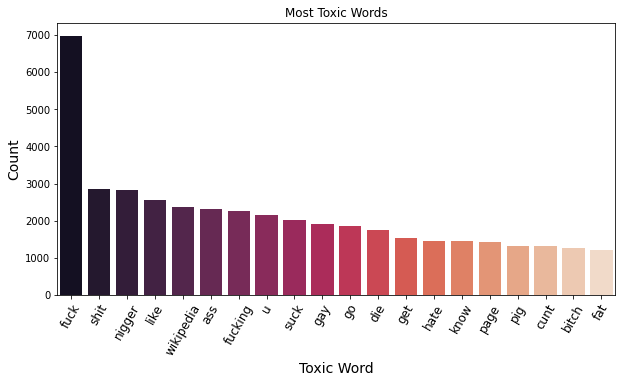

In [13]:
word,count=[],[]
for r,s in commonly_toxic.most_common(n=20):
  word.append(r)
  count.append(s)
print(word)
fig, ax = plt.subplots( figsize=(12,8))
#plt.bar(word,count)
plt.gcf().set_size_inches(10,5)
sns.barplot(word,count,palette='rocket')
plt.xlabel('Toxic Word', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=60,fontsize=12)
plt.title('Most Toxic Words')
plt.show()

  

###Word Cloud

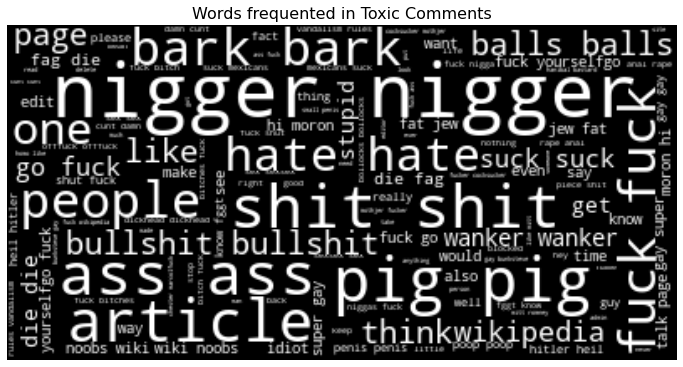

In [14]:
from wordcloud import WordCloud

def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(100, 200)

wc= WordCloud(background_color="black",max_words=200,stopwords=set(stopwords.words('english')))
wc.generate(" ".join(corpus))
plt.figure(figsize=(12,10))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=16)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
plt.show()

###Preprocessing Text

In [0]:
def clean_text(text):
    text=re.sub('[^a-zA-Z]', ' ',text)
    text=text.lower()
    text=text.split()
    lm = WordNetLemmatizer()
    text=[lm.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    #text=[word for word in text if not word in set(stopwords.words('english'))]
    text=' '.join(text)
    return text

In [0]:
train['comment_text'] = train['comment_text'].map(lambda x : clean_text(x))
test['comment_text'] = test['comment_text'].map(lambda x : clean_text(x))

In [0]:
X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [18]:
# tokenizing the data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

# turning the tokenized text into sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

# padding the sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63978, 200)


###ANN Model

In [0]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

In [0]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

####Model Architecture

In [21]:
# Initilize NN model
ann_model = Sequential()

# add embedding layer 
ann_model.add(Embedding(input_dim=max_features, input_length=max_len,output_dim=embedding_dims))

# add pooling layer 
# ... which will extract features from the embeddings of all words in the comment
ann_model.add(GlobalMaxPool1D())

# add dense layer to produce an output dimension of 50 and apply relu activation
ann_model.add(Dense(50, activation='relu'))

# set the regularizing dropout layer to drop out 30% of the nodes
ann_model.add(Dropout(0.3))

# finally add a dense layer
# ... which projects output into six units and squash it with sigmoid activation
ann_model.add(Dense(6, activation='sigmoid'))

In [24]:
ann_model.compile(loss='binary_crossentropy',optimizer=Adam(0.01), metrics=['accuracy'])

# check the model with all our layers
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,566,756
Trainable params: 2,566,756
Non-trainable params: 0
_________________________________________________________________


In [25]:
ann_hist = ann_model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.1)




Train on 143613 samples, validate on 15958 samples
Epoch 1/3





143613/143613 [==============================] - 160s 1ms/step - loss: 0.0666 - acc: 0.9780 - val_loss: 0.0633 - val_acc: 0.9789
Epoch 2/3
143613/143613 [==============================] - 159s 1ms/step - loss: 0.0549 - acc: 0.9801 - val_loss: 0.0561 - val_acc: 0.9801
Epoch 3/3
143613/143613 [==============================] - 158s 1ms/step - loss: 0.0516 - acc: 0.9806 - val_loss: 0.0608 - val_acc: 0.9797


In [26]:
# evaluate the algorithm on the test dataset
ann_test_loss, ann_test_auc = ann_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', ann_test_loss)
print('Test Accuracy:', ann_test_auc)

63978/63978 [==============================] - 3s 43us/step
Test Loss:     0.0807464779522182
Test Accuracy: 0.9685933564650516


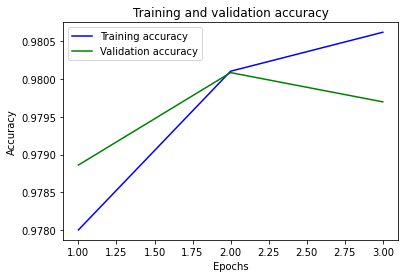

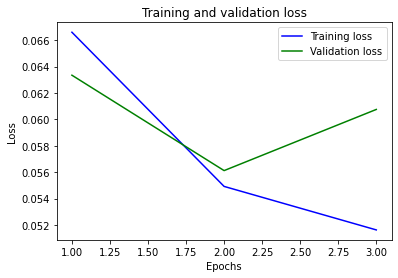

In [27]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(ann_hist)

###RNN Model

####RNN Architecture

In [0]:
# instantiate RNN model
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.5))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
rnn_model.add(Dense(6, activation='sigmoid'))

In [29]:
rnn_model.compile(loss='binary_crossentropy',optimizer=Adam(0.01),metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

In [30]:
rnn_hist = rnn_model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1229s 9ms/step - loss: 0.0705 - acc: 0.9767 - val_loss: 0.0573 - val_acc: 0.9802
Epoch 2/3
143613/143613 [==============================] - 1239s 9ms/step - loss: 0.0623 - acc: 0.9787 - val_loss: 0.0591 - val_acc: 0.9804
Epoch 3/3
143613/143613 [==============================] - 1224s 9ms/step - loss: 0.0617 - acc: 0.9788 - val_loss: 0.0579 - val_acc: 0.9800


In [31]:
rnn_test_loss, rnn_test_auc = rnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', rnn_test_loss)
print('Test Accuracy:', rnn_test_auc)

63978/63978 [==============================] - 87s 1ms/step
Test Loss:     0.07713137240828569
Test Accuracy: 0.9691456333173101


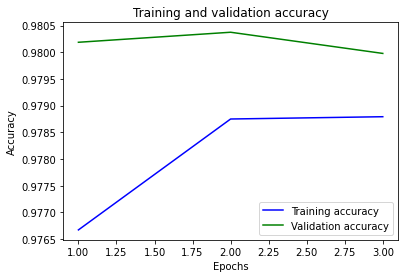

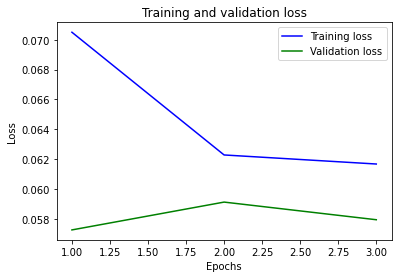

In [32]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(rnn_hist)